# BEE 4750 Homework 4: Linear Programming and Capacity Expansion

**Name**: Cella Schnabel, Matthew Hutchison, Tismark Boham

**ID**: rms428, mth77, etb62

> **Due Date**
>
> Thursday, 11/07/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to formulate and solve a resource allocation
    problem using linear programming.
-   Problem 2 asks you to formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   Problem 3 (5750 only) asks you to add a CO<sub>2</sub> constraint to
    the capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [120]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/4750coding/Homeworks/hw4-tiz-s-team`


In [121]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 50/60 Points)

### Problem 1 (20 points)

A farmer has access to a pesticide which can be used on corn, soybeans,
and wheat fields, and costs \$70/ha-yr to apply. The crop yields the
farmer can obtain following crop yields by applying varying rates of
pesticides to the field are shown in
<a href="#tbl-yields" class="quarto-xref">Table 1</a>.

| Application Rate (kg/ha) | Soybean (kg/ha) | Wheat (kg/ha) | Corn (kg/ha) |
|:------------------------:|:---------------:|:-------------:|:------------:|
|            0             |      2900       |     3500      |     5900     |
|            1             |      3800       |     4100      |     6700     |
|            2             |      4400       |     4200      |     7900     |

Table 1: Crop yields from applying varying pesticide rates for Problem
1.

The costs of production, *excluding pesticides*, for each crop, and
selling prices, are shown in
<a href="#tbl-costs" class="quarto-xref">Table 2</a>.

|   Crop   | Production Cost (\$/ha-yr) | Selling Price (\$/kg) |
|:--------:|:--------------------------:|:---------------------:|
| Soybeans |            350             |         0.36          |
|  Wheat   |            280             |         0.27          |
|   Corn   |            390             |         0.22          |

Table 2: Costs of crop production, excluding pesticides, and selling
prices for each crop.

Recently, environmental authorities have declared that farms cannot have
an *average* application rate on soybeans, wheat, and corn which exceeds
0.8, 0.7, and 0.6 kg/ha, respectively. The farmer has asked you for
advice on how they should plant crops and apply pesticides to maximize
profits over 130 total ha while remaining in regulatory compliance if
demand for each crop (which is the maximum the market would buy) this
year is 250,000 kg?

**In this problem**:

-   Formulate a linear program for this resource allocation problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations). **Tip: Make sure that all of your constraints are
    linear**.
-   Implement the program in `JuMP.jl` and find the solution. How many
    ha should the farmer dedicate to each crop and with what pesticide
    application rate(s)? How much profit will the farmer expect to make?
-   The farmer has an opportunity to buy an extra 10 ha of land. How
    much extra profit would this land be worth to the farmer? Discuss
    why this value makes sense and whether you would recommend the
    farmer should make the purchase.




For this problem, the objective is to maximize profit with constraints on pesticide use, land use and market cap. 


$\textbf {Variables}$\
First, we need to set all of our variables. Our nine variables come from our three crops, each having 3 treatment plans.\
Soy1 Soy2 and Soy3 represent Hectares of soy beans treated with pesticide plan '1' (0kg/ha) '2' (1kg/ha) or '3' (2kg/ha) respectively. This is repeated for Wheat and Corn

Soy1(ha)\
Soy2(ha)\
Soy3(ha)\
Wheat1(ha)\
Wheat2(ha)\
Wheat3(ha)\
Corn1(ha)\
Corn2(ha)\
Corn3(ha)


$\textbf {OBJECTIVE - Maximize Profit}$

To convert these Hectares to Kilograms of each crop, we will multiply by the expected yield for each crop/treatment combination:

$\rightarrow$ kgSoy1(kg) = Soy1(ha) * yieldSoy1(kg/ha) 

Then, total mass of Soy is calculated:

$\rightarrow$ totalKgSoy(kg) =  kgSoy1(kg) + kgSoy2(kg) + kgSoy2(kg)

Then, revenue and cost can be calculated based on the mass of produced soy:

$\rightarrow$ SoyRevenue(dollars) = totalKgSoy(kg)*soyPrice(dollars/kg)\
$\rightarrow$ SoyCost(dollars) = totalKgSoy(kg)*soyCost(dollars/kg)

Pesticide cost will be calculated per treatment option:\
(the final constant will be either 0, 1 or 2, in accordance with the application rate for the specific plan)

$\rightarrow$ pesticideCost(dollars) = Soy1(ha)*pesticidePrice(dollars/ha*yr)*0

This calculation will be repeated for each crop. Total cost  and revenue will be calculated by summing the values of all crops.
With these revenues and costs, we can calculate profit. 


$\star$ Profit = TotalRevenue - TotalProductionCost - TotalPesticideCost

$\textbf {CONSTRAINT 1 - pesticide use}$\
(repeat for each crop)

All of the land with soy planted on it must average to an application rate of 0.8 kg/ha or less. To write this constraint, we multiply the application rate by the amount of planted crop, and sum across all application types:\

$\rightarrow$ soy1(ha) * applicationRate1(kg/ha) + soy2(ha) * applicationRate2(kg/ha) + soy3(ha) * applicationRate3(kg/ha)

Then, ensure that this sum is less than total soy land * average limit

'' $\leq$ (Soy1 + Soy2 + Soy3)(ha) * 0.8(kg/ha)

$\textbf {CONSTRAINT 2 - land use}$

The total hectarage of land used must be 130ha or less

$\rightarrow$ Soy(ha) + Wheat(ha) + Corn (ha) $\leq$ 130(ha)

$\textbf {CONSTRAINT 3 - demand limit}$

Demand max is set at 250,000kg for each crop.

$\rightarrow$ Soy(kg) $\leq$ 250,000

Repeat for each crop





In [122]:
# what are we working with

pesticide = 70 # $/kg-ha-yr
# unit = kg/ha
soy0 = 2900 
soy1 = 3800 
soy2 = 4400 
# unit = $/kg
soy_sell = 0.36 
# unit = $/ha-yr
soy_cost = 350 

# unit = kg/ha
wheat0 = 3500 
wheat1 = 4100 
wheat2 = 4200 
# unit = $/kg
wheat_sell = 0.27
# unit = $/ha-yr
wheat_cost = 280

# unit = kg/ha
corn0 = 5900 
corn1 = 6700 
corn2 = 7900 
# unit = $/kg
corn_sell = 0.22
# unit = $/ha-yr
corn_cost = 390

# make the model
crop_model = Model(HiGHS.Optimizer)

# non-negativity connstraints in units ha
@variable(crop_model, all_soy[1:3]>=0)
@variable(crop_model, all_wheat[1:3]>=0)
@variable(crop_model, all_corn[1:3] >= 0)

# define the objectives and constraints
soy_kg = all_soy[1]*soy0 + all_soy[2]*soy1 + all_soy[3]*soy2
wheat_kg = all_wheat[1]*wheat0 + all_wheat[2]*wheat1 + all_wheat[3]*wheat2
corn_kg = all_corn[1]*corn0 + all_corn[2]*corn1 + all_corn[3]*corn2

total_rev = soy_sell*soy_kg + wheat_sell*wheat_kg + corn_sell*corn_kg
prod_cost = soy_cost*sum(all_soy)+ wheat_cost*sum(all_wheat) + corn_cost*sum(all_corn) 
# if you don't apply any pesticide then the application cost is zero -- cost in $/ha
pesticide_cost = pesticide * (all_soy[2] + 2*all_soy[3] + all_wheat[2] + 2*all_wheat[3] + all_corn[2] + 2*all_corn[3]) #$/ha-yr
total_cost = prod_cost + pesticide_cost

# proft = revenue - cost
profit = total_rev - total_cost

@objective(crop_model, Max, profit)
# constrained by pesticide use, demand, and total land available
# pesticide
@constraint(crop_model, soy_pesticide, all_soy[2] + 2*all_soy[3] <= 0.8 * sum(all_soy)) # checks average to be below 0.8
@constraint(crop_model, wheat_pesticide, all_wheat[2] + 2*all_wheat[3] <= 0.7 * sum(all_wheat))  
@constraint(crop_model, corn_pesticide, all_corn[2] + 2*all_corn[3] <= 0.6 * sum(all_corn)) 
# demand
@constraint(crop_model, soykg, soy_kg <= 250000)  
@constraint(crop_model, wheatkg, wheat_kg <= 250000) 
@constraint(crop_model, cornkg, corn_kg <= 250000)  
# land
@constraint(crop_model, land, sum(all_soy) + sum(all_wheat) + sum(all_corn) <= 130)
print(crop_model)

Max 694 all_soy[1] + 948 all_soy[2] + 1094 all_soy[3] + 665.0000000000001 all_wheat[1] + 757 all_wheat[2] + 714 all_wheat[3] + 908 all_corn[1] + 1014 all_corn[2] + 1208 all_corn[3]
Subject to
 soy_pesticide : -0.8 all_soy[1] + 0.19999999999999996 all_soy[2] + 1.2 all_soy[3] ≤ 0
 wheat_pesticide : -0.7 all_wheat[1] + 0.30000000000000004 all_wheat[2] + 1.3 all_wheat[3] ≤ 0
 corn_pesticide : -0.6 all_corn[1] + 0.4 all_corn[2] + 1.4 all_corn[3] ≤ 0
 soykg : 2900 all_soy[1] + 3800 all_soy[2] + 4400 all_soy[3] ≤ 250000
 wheatkg : 3500 all_wheat[1] + 4100 all_wheat[2] + 4200 all_wheat[3] ≤ 250000
 cornkg : 5900 all_corn[1] + 6700 all_corn[2] + 7900 all_corn[3] ≤ 250000
 land : all_soy[1] + all_soy[2] + all_soy[3] + all_wheat[1] + all_wheat[2] + all_wheat[3] + all_corn[1] + all_corn[2] + all_corn[3] ≤ 130
 all_soy[1] ≥ 0
 all_soy[2] ≥ 0
 all_soy[3] ≥ 0
 all_wheat[1] ≥ 0
 all_wheat[2] ≥ 0
 all_wheat[3] ≥ 0
 all_corn[1] ≥ 0
 all_corn[2] ≥ 0
 all_corn[3] ≥ 0


In [123]:
optimize!(crop_model)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 8e+03]
  Cost   [7e+02, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 2e+05]
Presolving model
7 rows, 9 cols, 27 nonzeros  0s
7 rows, 9 cols, 27 nonzeros  0s
Presolve : Reductions: rows 7(-0); columns 9(-0); elements 27(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.8170297740e+02 Ph1: 7(28.3601); Du: 9(181.703) 0s
          7     1.1674116702e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  1.1674116702e+05
HiGHS run time      :          0.00


In [124]:
@show value.(all_soy);
@show value.(all_wheat);
@show value.(all_corn);

@show value.(soykg);
@show value.(wheatkg);
@show value.(cornkg);

value.(all_soy) = [13.812154696132593, 55.24861878453038, 0.0]
value.(all_wheat) = [6.743306417339564, 15.73438164045898, 0.0]
value.(all_corn) = [26.923076923076927, 0.0, 11.538461538461554]
value.(soykg) = 250000.0
value.(wheatkg) = 88112.53718657029
value.(cornkg) = 250000.0


In [125]:
@show objective_value(crop_model);

objective_value(crop_model) = 116741.16702082449


$\textbf{\underline{Results}}$

After running the value and objective_value functions, we found that the farmer will make\
$116,741.17/yr \
if they follow the plan below:

Pesticide Treatment 1 - 0kg/ha\
Soy: 13.81 ha\
Wheat: 6.74 ha\
Corn: 26.9 ha

Pesticide Treatment 2 - 1kg/ha\
Soy: 55.25 ha\
Wheat: 15.73 ha\
Corn: 0.00 ha

Pesticide Treatment 3 - 2kg/ha\
Soy: 0.00 ha\
Wheat: 0.00 ha\
Corn: 11.54 ha

$\textbf{\underline{Part 3}}$

Now we can solve the final question. To do so, we will rerun the optimization but change the land constraint to 140ha


In [126]:
# make the model
crop_model = Model(HiGHS.Optimizer)

# non-negativity connstraints in units ha
@variable(crop_model, all_soy[1:3]>=0)
@variable(crop_model, all_wheat[1:3]>=0)
@variable(crop_model, all_corn[1:3] >= 0)

# define the objectives and constraints
soy_kg = all_soy[1]*soy0 + all_soy[2]*soy1 + all_soy[3]*soy2
wheat_kg = all_wheat[1]*wheat0 + all_wheat[2]*wheat1 + all_wheat[3]*wheat2
corn_kg = all_corn[1]*corn0 + all_corn[2]*corn1 + all_corn[3]*corn2

total_rev = soy_sell*soy_kg + wheat_sell*wheat_kg + corn_sell*corn_kg
prod_cost = soy_cost*sum(all_soy)+ wheat_cost*sum(all_wheat) + corn_cost*sum(all_corn) 
# if you don't apply any pesticide then the application cost is zero -- cost in $/ha
pesticide_cost = pesticide * (all_soy[2] + 2*all_soy[3] + all_wheat[2] + 2*all_wheat[3] + all_corn[2] + 2*all_corn[3]) #$/ha-yr
total_cost = prod_cost + pesticide_cost

# proft = revenue - cost
profit = total_rev - total_cost

@objective(crop_model, Max, profit)
# constrained by pesticide use, demand, and total land available
# pesticide
@constraint(crop_model, soy_pesticide, all_soy[2] + 2*all_soy[3] <= 0.8 * sum(all_soy)) # checks average to be below 0.8
@constraint(crop_model, wheat_pesticide, all_wheat[2] + 2*all_wheat[3] <= 0.7 * sum(all_wheat))  
@constraint(crop_model, corn_pesticide, all_corn[2] + 2*all_corn[3] <= 0.6 * sum(all_corn)) 
# demand
@constraint(crop_model,soykg, soy_kg <= 250000)  
@constraint(crop_model,wheatkg, wheat_kg <= 250000) 
@constraint(crop_model,cornkg, corn_kg <= 250000)  
# land
@constraint(crop_model, land, sum(all_soy) + sum(all_wheat) + sum(all_corn) <= 140)
print(crop_model)

Max 694 all_soy[1] + 948 all_soy[2] + 1094 all_soy[3] + 665.0000000000001 all_wheat[1] + 757 all_wheat[2] + 714 all_wheat[3] + 908 all_corn[1] + 1014 all_corn[2] + 1208 all_corn[3]
Subject to
 soy_pesticide : -0.8 all_soy[1] + 0.19999999999999996 all_soy[2] + 1.2 all_soy[3] ≤ 0
 wheat_pesticide : -0.7 all_wheat[1] + 0.30000000000000004 all_wheat[2] + 1.3 all_wheat[3] ≤ 0
 corn_pesticide : -0.6 all_corn[1] + 0.4 all_corn[2] + 1.4 all_corn[3] ≤ 0
 soykg : 2900 all_soy[1] + 3800 all_soy[2] + 4400 all_soy[3] ≤ 250000
 wheatkg : 3500 all_wheat[1] + 4100 all_wheat[2] + 4200 all_wheat[3] ≤ 250000
 cornkg : 5900 all_corn[1] + 6700 all_corn[2] + 7900 all_corn[3] ≤ 250000
 land : all_soy[1] + all_soy[2] + all_soy[3] + all_wheat[1] + all_wheat[2] + all_wheat[3] + all_corn[1] + all_corn[2] + all_corn[3] ≤ 140
 all_soy[1] ≥ 0
 all_soy[2] ≥ 0
 all_soy[3] ≥ 0
 all_wheat[1] ≥ 0
 all_wheat[2] ≥ 0
 all_wheat[3] ≥ 0
 all_corn[1] ≥ 0
 all_corn[2] ≥ 0
 all_corn[3] ≥ 0


In [127]:
optimize!(crop_model)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 8e+03]
  Cost   [7e+02, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 2e+05]
Presolving model
7 rows, 9 cols, 27 nonzeros  0s
7 rows, 9 cols, 27 nonzeros  0s
Presolve : Reductions: rows 7(-0); columns 9(-0); elements 27(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.8170297740e+02 Ph1: 7(28.3601); Du: 9(181.703) 0s
          7     1.2403516702e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  1.2403516702e+05
HiGHS run time      :          0.00


In [128]:
@show value.(all_soy);
@show value.(all_wheat);
@show value.(all_corn);

@show value.(soykg);
@show value.(wheatkg);
@show value.(cornkg);


value.(all_soy) = [13.81215469613259, 55.2486187845304, 0.0]
value.(all_wheat) = [9.743306417339566, 22.734381640458984, 0.0]
value.(all_corn) = [26.923076923076923, 0.0, 11.538461538461522]
value.(soykg) = 250000.0
value.(wheatkg) = 127312.53718657032
value.(cornkg) = 250000.0


In [129]:
@show objective_value(crop_model);

objective_value(crop_model) = 124035.16702082446


$\textbf{\underline{Part 3 Results}}$
 
 When the function is run again with the land constraint shifted to 140ha (10 more hectares of land available), the total profit increases by $7,294.01 to $124,035.17/yr. This makes sense, once we analyzed how much of each crop is grown in both cases. At 130ha of land, we showed the value of the demand constraint, and only ~88,000kg of wheat were being produced and sold while the other crops were maximized at 250,000kg. This means that with more land, the farmer could grow more wheat and there would be a demand for it. This was indeed the case, as when we reran the function with 10ha more land, wheat production was the only crop production to change.

 I would recommend that the farmer makes this purchase if:
 1. The price of the land will be returned in a reasonable time from the additional ~$7,000 yearly
 2. If the farmer expects demand for wheat to remain high in the coming years


### Problem 2 (30 points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.


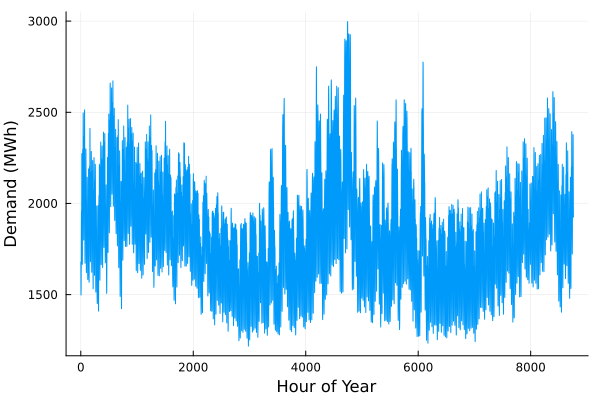

In [130]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data, shown in
<a href="#tbl-generators" class="quarto-xref">Table 3</a>. This data
includes fixed costs (\$/MW installed), variable costs (\$/MWh
generated), and CO<sub>2</sub> emissions intensity (tCO<sub>2</sub>/MWh
generated).

In [131]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

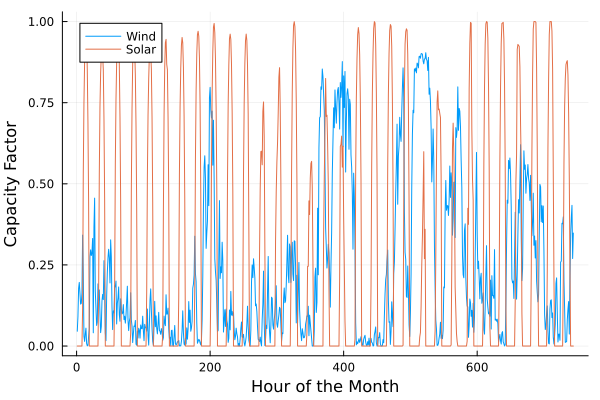

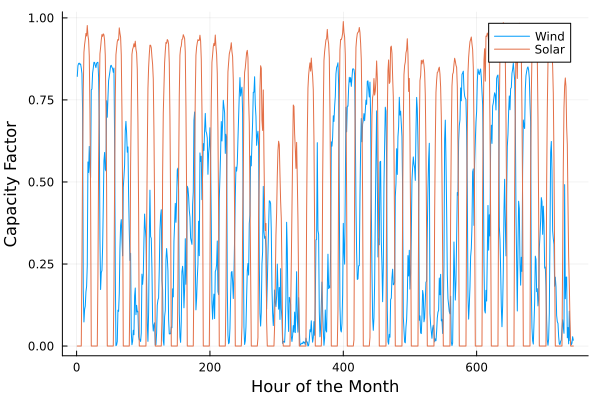

In [132]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley County, NY, which currently has no existing
electrical generation infrastructure. The utility can build any of the
following plant types: geothermal, coal, natural gas combined cycle gas
turbine (CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$10,000/MWh.

**In this problem**:

-   Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).
-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?
-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 1.5? Do these results make sense given the generator
    data?
-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision! If your number is on a different order of magnitude and you
> want to round to a certain number of significant digits, you can use
> `round(x; sigdigits=n)`.

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.


For this problem, the objective is to minimize cost with constraints on power demand and generator capacity. There is also a penalty on non-served energy.


$\textbf {Variables}$\
Our variables include the capacity of each generator that we install (called 'x'), the production of each of these generators (called 'y'), and the energy that we do not supply (non-served energy 'NSE').\


x1 $\rightarrow$ x6 (MW installed)\
y1 $\rightarrow$ y6 (MWh produced)\
NSE (MWh)



$\textbf {OBJECTIVE - Minimize Cost}$

The basic equation for the cost of this production looks like this:

$\star Cost = \underline{Initial Cost} + \underline{Variable Cost} + \underline{NSEC}$

This equation can be filled out by our variables using summations. (In our code, we execute these summations using vector notation and forecasting.)

Initial cost(dollars) is the Fixed Cost (dollars/MW installed) multiplied by the total capacity installed (MW)

$\underline{Initial Cost} = \sum_{g \in G} Fixed Cost * x_g$

Variable cost(dollars) is the production cost (dollars/MW) multiplied by the total production (MW). This is dependant on time, so we have to sum over all generators and over all time. 


$\underline{Variable Cost} = \sum_{t \in T}\sum_{g \in G} Variable Cost * y_g,t$

Finally, Non-Served Energy Cost (NSEC) is the price per NSE (dollars/MWh) times to total NSE (MWh). THis only varies over time, it does not vary by generator. Thus we only sum over time

$\underline{NSEC} = \sum_{t \in T} NSEC * NSE_t$


$\textbf {CONSTRAINT 1 - Capacity}$\
For each generator, they cannot produce more energy than their installed capacity. We can set this constraint with the equation:

$y_g,t \leq x_g$

But we also need to consider the capacity factors, which vary with time. These will be multiplied by installed capacity x to ensure that the simulation does not suppose a generator can produce more power than it truly can.

$\rightarrow  y_g,t \leq x_g * capacityFactor_t$


$\textbf {CONSTRAINT 2 - Demand}$

We must ensure that we are always meeting the demand. While we do have Non-served energy, this must be included in the "demand" constraint to show how much of the demand we missed. It ends up being a sum of our total production (from every generator) and our NSE.

$ \rightarrow Demand_t \leq NSE_t + \sum_{g \in G}y_g,t$

Finally we can run our function to solve the objectives:





In [133]:
#BELOW IS FROM LECTURE 
# define sets
#set out vectors based on the data provided
G = 1:6# number of generators
T = 1:nrow(demand) #time steps
NSECost = 10000 #defined in problem statement

#capacity factors
#initialize empty matrix
# 1 has .85, 1 for 2-4, load based on data for 5 and 6
#initialize the matrix with zeroes, 
    #error recommended broadcasting the equal sign
    c = zeros(6,8760);
    #then fill in the columns based on row (generator type)
    c[1,:] .= 0.85;
    c[2,:] .= 1;
    c[3,:] .= 1;
    c[4,:] .= 1;
    #for wind and solar, we gotta get them from the data
    c[5,:] .= cap_factor.Wind[:];
    c[6,:] .= cap_factor.Solar[:];
    
gencap = Model(HiGHS.Optimizer)
# define variables
#x is the installed capacity of each generator
#y is how much each generator produces
#NSE is how much energy cannot be supplied, but is asked for (demanded)
@variables(gencap, begin
    x[g in G] >= 0 #capacity 
    y[g in G, t in T] >= 0 #production
    NSE[t in T] >= 0
end)



#the main goal is to minimize the cost of the system
#each fixed cost times x because its unit price ($/MW) times number of units (MW)
@objective(gencap, Min, sum(gens[G, :FixedCost] .* x) + sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + (NSECost * sum(NSE))
)


#our constraints are...
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= demand.Demand[t]) # we must meet demand
#ADD CAPACITIES
@constraint(gencap, availability[g in G, t in T], y[g, t] <= x[g]*c[g,t]) #each generator cannot produce more than its capapcity
optimize!(gencap)



Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [5e-05, 1e+00]
  Cost   [2e+01, 4e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+03, 3e+03]
Presolving model
56856 rows, 56862 cols, 153048 nonzeros  0s
56853 rows, 56859 cols, 153042 nonzeros  0s
Presolve : Reductions: rows 56853(-4467); columns 56859(-4467); elements 153042(-8934)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.1747e+06) 0s
      41728     6.5455876886e+08 Pr: 732(15260.5); Du: 0(3.17894e-06) 6s
      42008     6.5458487038e+08 Pr: 0(0); Du: 0(2.07029e-10) 6s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 42008
Objective value     :  6.5458487038e+08
HiGHS run time      :          6.05


$\textbf {Question 2 answers}$

Here we are going to check the total cost to install and run the plant for a year by running show objective value. 

The code tells us it will be $\underline {6.55*10^8 dollars}$ to build the optimal installation.


In [134]:
@show objective_value.(gencap)

objective_value.(gencap) = 6.54584870381541e8


6.54584870381541e8

We will also show how much (MWh) capacity of each generator we installed, using show value x. This will help us build our percentage of each generator installed ratios. Optimally, we need to install:

0.0 (MW) Geothermal\
0.0 (MW) Coal\
1,658.45 (MW) NG CCGT\
879.75 (MW) NG CT\
484.95 (MW) Wind\
1,957.64 (MW) Solar



In [135]:
@show value.(x)

value.(x) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
   -0.0
    0.0
 1658.4514133074133
  879.7538120149645
  484.946167110047
 1957.6424239086684


1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
   -0.0
    0.0
 1658.4514133074133
  879.7538120149645
  484.946167110047
 1957.6424239086684

Next we will show the value of the sum of NSE, the non served energy for the whole time. This will show us how much energy we didn't provide for the whole year.

The total non served energy will be $\underline{256.83 (MW)}$

In [136]:
@show sum(value.(NSE))

sum(value.(NSE)) = 256.83377442738583


256.83377442738583

Next we need to figure out the total energy produced each year, and then what percent each generator makes up in this production.

In [137]:
totalGen = sum(value.(y[:,:]))
@show totalGen

totalGen = 1.6367649066225475e7


1.6367649066225475e7

In [138]:
frac1 =  sum(value.(y[1,:]))/(totalGen)
frac2 =  sum(value.(y[2,:]))/(totalGen)
frac3 =  sum(value.(y[3,:]))/(totalGen)
frac4 =  sum(value.(y[4,:]))/(totalGen)
frac5 =  sum(value.(y[5,:]))/(totalGen)
frac6 =  sum(value.(y[6,:]))/(totalGen)

0.3564605837632996

$ \textbf {Of the total annual generation, the percent production is shown below}$:

0.0 % Geothermal\
0.0 % Coal\
52.89 % NG CCGT\
2.75 % NG CT\
8.72 % Wind\
35.64 % Solar

This is similar to the breakdown of installed capacity for each generator, With Solar and NG CCGT having higher installed capacities and higher productions than Wind and NG CT. Also, Geothermal and Coal are 0 in both. What is interesting is that we installed about 1/2 as much NG CT than NG CCGT, yet NG CCGT is producing far more than half of our energy, almost 25x more!

It makes sense that solar produces a smaller percentage than NG CCGT even though it has a higher installed capacity. This is because solar has a variable capacity factor that is often below 1, meaning it cannot always produce it maximum energy. At the same time, NG CCGT has a capacity factor of 1, meaning it can always be used at 100% capacity.

$\textbf {Plot for Question 2}$

Finally we need to plot the electricity price in each hour. This value represents how much it costs the plant to run per hour. 

Only Coal, NG CCGT, and NG CT have variable costs. Thus, we only need to calculate the hourly production cost for NG CCGT and NG CT.

This can be done by first calculating each generator's energy produced in each time step (MW), and multiplying it by the variable cost of production per hour (dollars/MW). 

$\rightarrow$ NG CCGT Cost in Hour 't' (dollars) = NG CCGT production (MW) * cost to produce NG CCGT (dollar/MW)

$\rightarrow$ NG CT Cost in Hour 't' (dollars) = NG CT production (MW) * cost to produce NG CT (dollar/MW)

$\rightarrow$ Total Cost in hour 't' (dollars) =  NG CCGT Cost in Hour 't' (dollars) + NG CT Cost in Hour 't' (dollars)

This will be done for all t, with the total cost saved in a vector and then plotted on the y axis against time on the x axis.


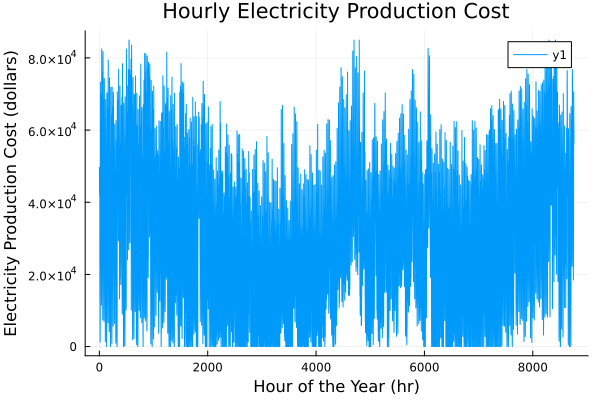

In [140]:
#first make a variable to hold the x axis TIME
time = [1:8760]
#next make the y axis, by multiplying each production by its respective variable cost.
#for NGCCGT


vCost1 = 30;
t = 1;
for t in time
    NGCCGTvec[t,1] = value.(y[3,t]) * vCost1;
end
#repeat for NGCCG
vCost2 = 40;
#reset time
t = 1;
for t in time
    NGCTvec[t,1] = value.(y[4,t]) * vCost2;
end

#sum the two into a final vector
finalCostVec = NGCTvec .+ NGCCGTvec

plot(time, finalCostVec, title="Hourly Electricity Production Cost", xlabel = "Hour of the Year (hr)", ylabel = "Electricity Production Cost (dollars)")


$\textbf{Graph Interpretation}$

The graph looks thick because there is a mapped point at every hour, and througout each day there is high variation in the energy demand and thus production (less at noon than at night). This means the lines jump up and down frequently.

The main trend here is that energy is most expensive in the winter months. This makes sense, as there is higher demand for heating, forcing higher production in these months. The interesting peak is the increase near the middle of the year. This could be because these months are very hot, and demand for electricity is high to run AC units, thus causing higher production and higher production costs.



### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

**In this problem**:

-   Reformulate your linear program from Problem 2 with any necessary
    changes to capture the CO<sub>2</sub> limit.
-   Implement the new optimization problem and find the optimal
    solution. How much should the utility build of each type of
    generating plant? What is different from your plan from Problem 1?
    Do these changes make sense?
-   What would the value to the utility be of allowing it to emit an
    additional 1000 tCO<sub>2</sub>/yr? An additional 5000?
    

## References

List any external references consulted, including classmates.